In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency

# Set random seed for reproducibility
np.random.seed(42)

# Load the January 2020 dataset
#url = "D:\Sem6\d3_predictive_analysis\Datasets\green_tripdata_2020-01.parquet"
df = pd.read_parquet("D:\Sem6\d3_predictive_analysis\Datasets\green_tripdata_2020-01.parquet")

# Display basic info
# a) Import data & info() 

## Data Preparation

In [26]:
# b) Drop ehail_fee column
df = df.drop('ehail_fee', axis=1)

In [27]:
# c) Calculate trip_duration in minutes
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

In [28]:
# d) Extract weekday from dropoff date
df['weekday'] = df['lpep_dropoff_datetime'].dt.weekday
print("\nWeekday value counts:")
print(df['weekday'].value_counts())


Weekday value counts:
weekday
4    80950
3    78330
2    71687
1    59579
5    54016
0    53783
6    49425
Name: count, dtype: int64


In [29]:
# e) Extract hour from dropoff date
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour
print("\nHour of day value counts:")
print(df['hourofday'].value_counts())


Hour of day value counts:
hourofday
18    31237
17    30045
16    29866
15    27968
19    27784
10    26358
9     26136
14    25499
12    24993
11    24821
13    24772
20    22465
8     21815
21    19194
22    17018
23    13747
7     13029
0     10453
1      7053
6      6210
2      5060
4      4308
5      4117
3      3822
Name: count, dtype: int64


In [30]:
# f) Missing Values Imputation
print("\nMissing values before imputation:")
print(df.isnull().sum())


Missing values before imputation:
VendorID                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag       116051
RatecodeID               116051
PULocationID                  0
DOLocationID                  0
passenger_count          116051
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
payment_type             116051
trip_type                116052
congestion_surcharge     116051
trip_duration                 0
weekday                       0
hourofday                     0
dtype: int64


In [31]:
# Impute missing values with appropriate methods
df['RatecodeID'].fillna(df['RatecodeID'].mode()[0], inplace=True)
df['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0], inplace=True)
df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)
df['payment_type'].fillna(df['payment_type'].mode()[0], inplace=True)
df['trip_type'].fillna(df['trip_type'].mode()[0], inplace=True)
df['congestion_surcharge'].fillna(0, inplace=True)  # Assuming no congestion surcharge if missing

print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
trip_duration            0
weekday                  0
hourofday                0
dtype: int64


## Visualization

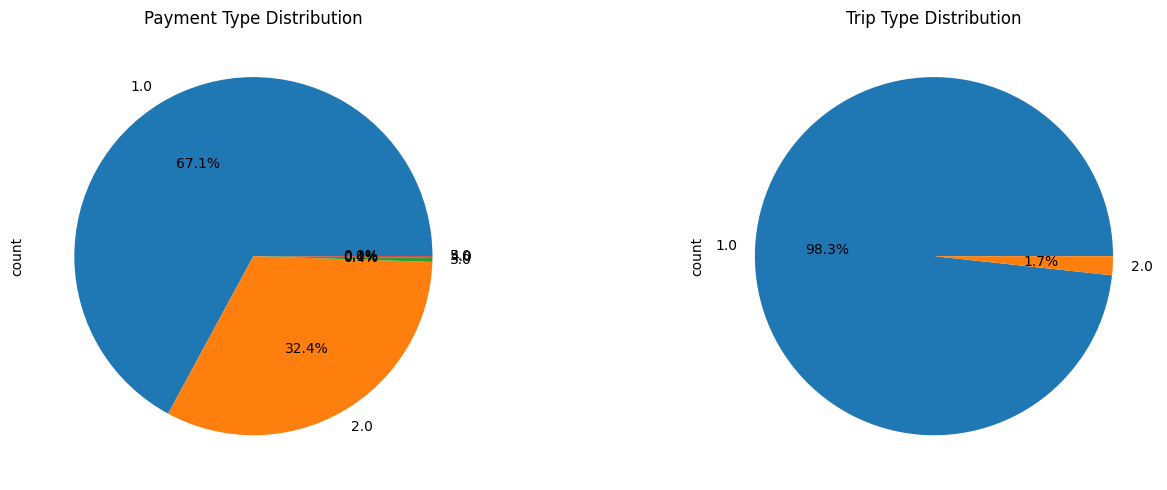

In [32]:
# g) Pie diagrams
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
df['payment_type'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Payment Type Distribution')

plt.subplot(1, 2, 2)
df['trip_type'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Trip Type Distribution')

plt.tight_layout()
plt.show()

## Groupby Analysis

In [33]:
# h) Groupby average total_amount & weekday
print("\nAverage total amount by weekday:")
print(df.groupby('weekday')['total_amount'].mean())


Average total amount by weekday:
weekday
0    18.845397
1    19.448136
2    19.341780
3    19.292317
4    18.832199
5    17.721758
6    18.422195
Name: total_amount, dtype: float64


In [34]:
# i) Groupby average total_amount & payment_type
print("\nAverage total amount by payment type:")
print(df.groupby('payment_type')['total_amount'].mean())


Average total amount by payment type:
payment_type
1.0    22.342067
2.0    12.031307
3.0     1.763146
4.0     2.403907
5.0    12.350000
Name: total_amount, dtype: float64


In [35]:
# j) Groupby average tip_amount & weekday
print("\nAverage tip amount by weekday:")
print(df.groupby('weekday')['tip_amount'].mean())


Average tip amount by weekday:
weekday
0    0.900450
1    0.853846
2    0.920944
3    0.866565
4    0.886909
5    0.970021
6    0.920753
Name: tip_amount, dtype: float64


In [36]:
# k) Groupby average tip_amount & payment_type
print("\nAverage tip amount by payment type:")
print(df.groupby('payment_type')['tip_amount'].mean())


Average tip amount by payment type:
payment_type
1.0    1.340972
2.0    0.000042
3.0   -0.005701
4.0    0.000000
5.0    0.000000
Name: tip_amount, dtype: float64


## Statistical Test

In [37]:
# l) Test null average total_amount of different trip_type is identical
trip_type_groups = [df[df['trip_type'] == i]['total_amount'] for i in df['trip_type'].unique()]
f_stat, p_val = f_oneway(*trip_type_groups)
print(f"\nANOVA test for total_amount across trip types: F-stat={f_stat:.2f}, p-value={p_val:.4f}")


ANOVA test for total_amount across trip types: F-stat=113.69, p-value=0.0000


In [38]:
# m) Test null average total_amount of different weekday is identical
weekday_groups = [df[df['weekday'] == i]['total_amount'] for i in range(7)]
f_stat, p_val = f_oneway(*weekday_groups)
print(f"ANOVA test for total_amount across weekdays: F-stat={f_stat:.2f}, p-value={p_val:.4f}")

ANOVA test for total_amount across weekdays: F-stat=109.74, p-value=0.0000


In [39]:
# n) Test null no association between trip_type and payment_type
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test for association between trip_type and payment_type: chi2={chi2:.2f}, p-value={p:.4f}")

Chi-square test for association between trip_type and payment_type: chi2=1860.84, p-value=0.0000


## Variable Analysis

In [40]:
# o) Numeric variables
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 
                'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 
                'trip_duration', 'passenger_count']
print("\nNumeric variables summary statistics:")
print(df[numeric_cols].describe())


Numeric variables summary statistics:
       trip_distance    fare_amount          extra        mta_tax  \
count  447770.000000  447770.000000  447770.000000  447770.000000   
mean        3.599392      15.839504       0.838858       0.388785   
std         4.257709      12.691982       1.149168       0.210808   
min       -33.690000    -210.000000      -4.500000      -0.500000   
25%         1.080000       7.000000       0.000000       0.500000   
50%         2.070000      11.500000       0.500000       0.500000   
75%         4.410000      21.000000       1.000000       0.500000   
max       130.680000     753.000000       8.250000       3.550000   

          tip_amount   tolls_amount  improvement_surcharge  \
count  447770.000000  447770.000000          447770.000000   
mean        0.899788       0.327172               0.287046   
std         2.319882       1.458425               0.064305   
min        -2.800000      -6.120000              -0.300000   
25%         0.000000       0.

In [41]:
# p) Object variables
object_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday']
print("\nObject variables summary:")
print(df[object_cols].astype('object').describe())



Object variables summary:
       store_and_fwd_flag  RatecodeID  payment_type  trip_type  weekday  \
count              447770    447770.0      447770.0   447770.0   447770   
unique                  2         7.0           5.0        2.0        7   
top                     N         1.0           1.0        1.0        4   
freq               446727    438740.0      300455.0   440130.0    80950   

        hourofday  
count      447770  
unique         24  
top            18  
freq        31237  


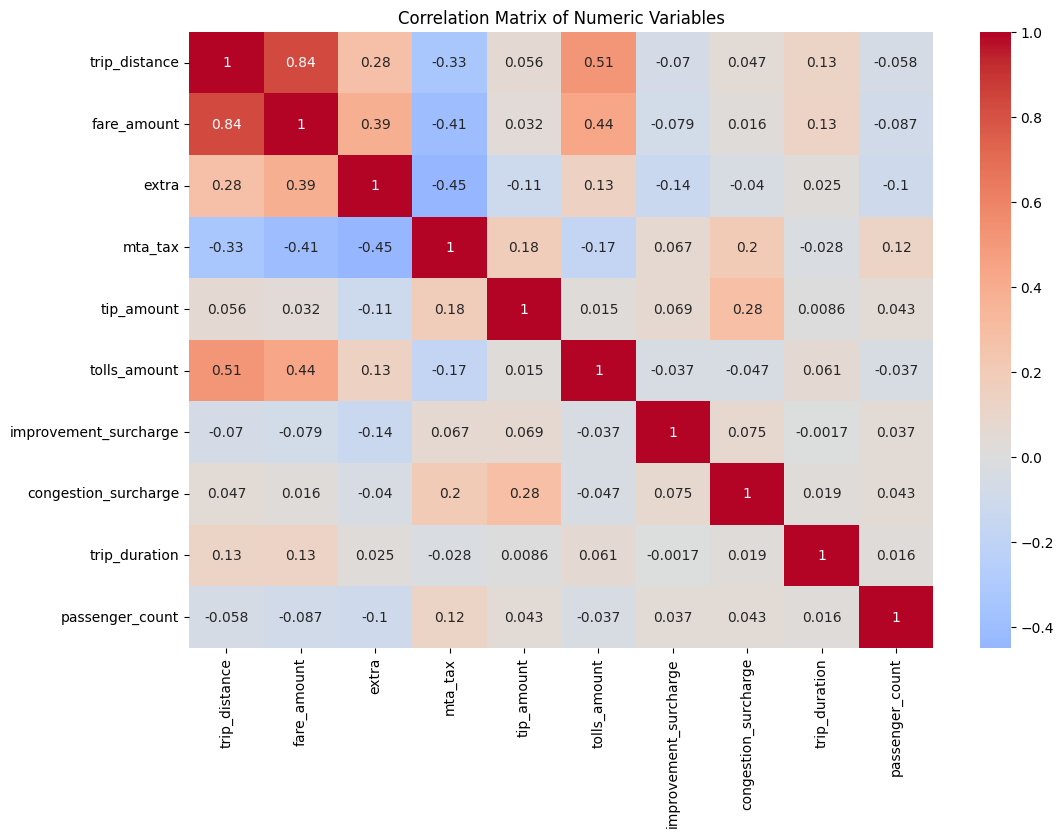

In [42]:
# q) Correlation analysis of numeric cols
plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

## Data Preparation for model

In [ ]:
# r) Dummy encode object cols
df_encoded = pd.get_dummies(df, columns=['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday'])


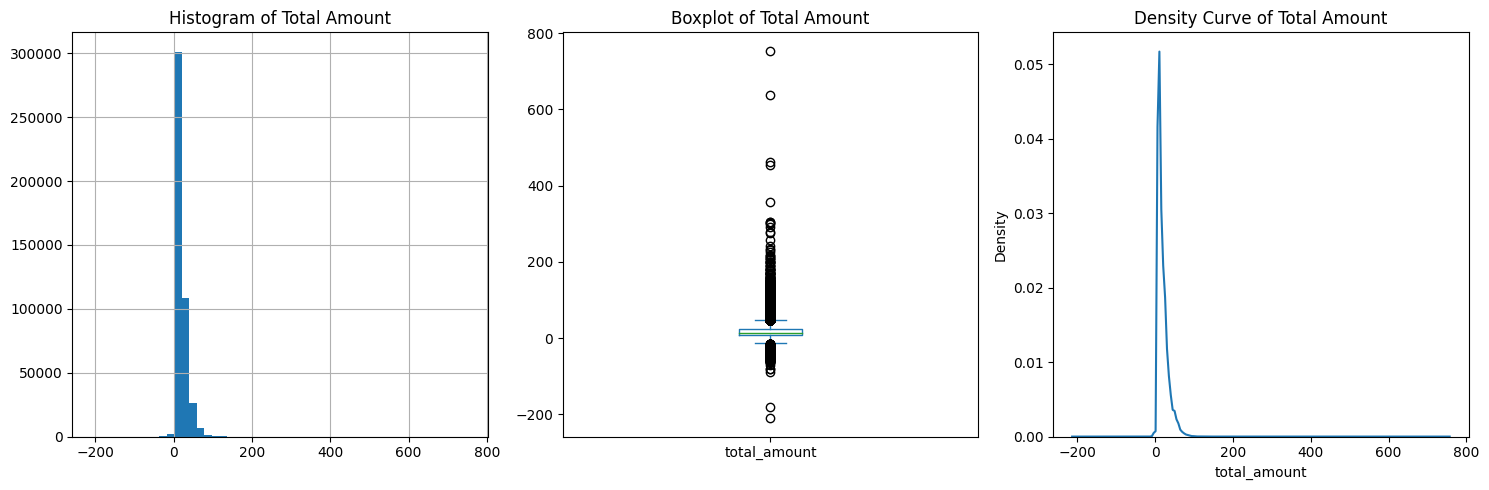

In [44]:
# s) Dependent Variable analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['total_amount'].hist(bins=50)
plt.title('Histogram of Total Amount')

plt.subplot(1, 3, 2)
df['total_amount'].plot(kind='box')
plt.title('Boxplot of Total Amount')

plt.subplot(1, 3, 3)
sns.kdeplot(df['total_amount'])
plt.title('Density Curve of Total Amount')

plt.tight_layout()
plt.show()

## Regression Models

In [45]:
# Prepare features and target
X = df_encoded.drop(['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'VendorID'], axis=1, errors='ignore')
y = df_encoded['total_amount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# t) Build regression models
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        'Model': name,
        'RMSE': rmse,
        'R-squared': r2
    })
    
    # Print feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        print(f"\n{name} Feature Importances:")
        importances = pd.Series(model.feature_importances_, index=X.columns)
        print(importances.sort_values(ascending=False).head(10))

# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)


Decision Tree Feature Importances:
fare_amount             0.953155
tip_amount              0.032293
tolls_amount            0.007776
congestion_surcharge    0.002943
extra                   0.002912
DOLocationID            0.000383
trip_distance           0.000116
trip_duration           0.000076
hourofday_0             0.000067
PULocationID            0.000067
dtype: float64

Random Forest Feature Importances:
fare_amount             0.953376
tip_amount              0.031446
tolls_amount            0.007473
congestion_surcharge    0.003006
extra                   0.002918
trip_distance           0.000876
PULocationID            0.000152
trip_duration           0.000118
DOLocationID            0.000108
weekday_0               0.000087
dtype: float64

Gradient Boosting Feature Importances:
fare_amount             0.943997
tip_amount              0.030982
tolls_amount            0.012765
congestion_surcharge    0.004861
extra                   0.004360
trip_distance           0.002388
